# EE 508 HW 4: CUDA Programming

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

In [2]:
!pip install Ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F

from torch.utils.cpp_extension import load_inline
import time

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device", device)

Device cuda


Define the same helper functions as in HW 3 with slight modifications. Note that input variables are moved to GPU memory after declaration. For benchmarking, we will perform matrix multiplication between two inputs, both of size **4096 × 4096**.

In [5]:
def check_correctness(func, dtype=torch.float32):
    """
    Check correctness of the custom kernel.
    """
    # Define input tensors
    torch.manual_seed(508)
    A = torch.randn(32, 32, dtype=dtype).to("cuda")
    B = torch.randn(32, 32, dtype=dtype).to("cuda")

    # Perform matrix multiplication using the custom kernel
    my_results = func(A, B)

    # Perform matrix multiplication using PyTorch
    pt_results = torch.matmul(A, B)

    # Compare results
    if torch.allclose(my_results, pt_results, atol=1e-6):
        print("Results match!")
    else:
        print("Results do not match!")
        print(f"my_results: {my_results}")
        print(f"pt_results: {pt_results}")


def benchmark_matmul(func, num_runs=3, warmup_runs=3, size=4096, dtype=torch.float32):
    """
    Benchmark a matrix multiplication function and compare it with PyTorch's matmul.

    Parameters:
    - func: The custom function to benchmark.
    - num_runs: Number of timed executions for measurement.
    - warmup_runs: Number of warm-up executions.
    - size: Matrix dimension (size x size).
    """

    # Define input tensors
    torch.manual_seed(508)
    A = torch.randn(size, size, dtype=dtype).to("cuda")
    B = torch.randn(size, size, dtype=dtype).to("cuda")

    def measure_flops(kernel_func):
        """Helper function to measure FLOPs per second for a given function."""

        # Warm-up phase
        for _ in range(warmup_runs):
            kernel_func(A, B)

        # Synchronize before timing
        torch.cuda.synchronize()

        # Measure execution time over multiple runs
        start_time = time.perf_counter()
        for _ in range(num_runs):
            kernel_func(A, B)
        torch.cuda.synchronize()  # Ensure all GPU operations finish
        end_time = time.perf_counter()

        # Compute average time per run
        avg_time = (end_time - start_time) / num_runs

        # Estimate FLOPs: 2 * (m * n * p) for standard matrix multiplication
        flops = 2 * size * size * size
        flops_per_sec = flops / avg_time

        return flops_per_sec, avg_time

    # Benchmark the custom kernel
    print("Benchmarking custom kernel...")
    flops_per_sec, avg_time = measure_flops(func)
    print(f"My kernel TFLOPs per second: {(flops_per_sec * 1e-12):.5f}, Average time: {avg_time:.5f} sec")

    # Benchmark PyTorch's matmul
    print("\nBenchmarking PyTorch matmul...")
    flops_per_sec, avg_time = measure_flops(torch.matmul)
    print(f"PyTorch TFLOPs per second: {(flops_per_sec * 1e-12):.5f}, Average time: {avg_time:.5f} sec")

## NVIDIA T4 Tensor Core GPU

Google Colab provides free access to [NVIDIA T4 Tensor Core GPU](https://www.nvidia.com/en-us/data-center/tesla-t4/). Based on the Turing architecture, it features **2,560 CUDA cores** and **320 Tensor Cores**, offering a theoretical peak performance of **8.1 TFLOPS** for single-precision (FP32) and **65 TFLOPS** for mixed-precision (FP16/FP32) computations.

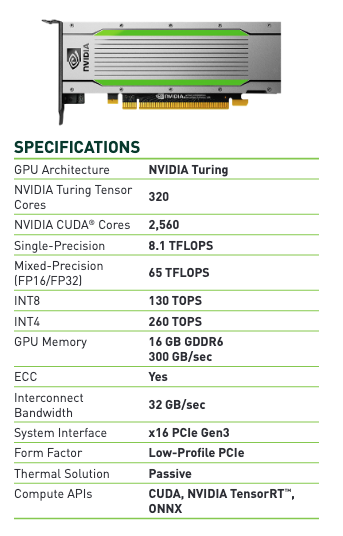

## CUDA Naive Matrix Multiplication

#### Global Thread Indexing in CUDA

In CUDA's naive matrix multiplication implementation, each thread is responsible for computing a single element of the output matrix. To correctly access elements, we need to compute the **global thread index** for each element. The image below provides an example setup with:

- Block dimension: 4 × 4 (each block contains 16 threads)
- Grid dimension: 2 × 2 (total of 4 blocks)

Each thread's global index is computed as:

* `global_row_idx = blockIdx.y * blockDim.y + threadIdx.y`
* `global_col_idx = blockIdx.x * blockDim.x + threadIdx.x`

Using this equation, we can analyze the indexing pattern:

- Block (0,0) (green): Threads have `threadIdx` values ranging from (0,0) to (3,3).
  - Their global indices remain the same since they are in the first block.
- Block (1,0) (blue): Threads are shifted by 4 in the x-direction.
  - `global_col_idx = threadIdx.x + 4`
- Block (0,1) (black): Threads are shifted by 4 in the y-direction.
  - `global_row_idx = threadIdx.y + 4`
- Block (1,1) (red): Threads are shifted by 4 in both x and y directions.
  - `global_row_idx = threadIdx.y + 4`
  - `global_col_idx = threadIdx.x + 4`



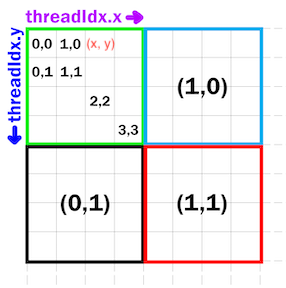

In the code example below, we implement a naive version of matrix multiplication using global memory only and integrate it into PyTorch following the same approach as HW3.

- Block dimension: 32 × 32
- Grid dimension: 4096/32 × 4096/32 = 128 x 128

We do not need to manually allocate or deallocate CUDA memory or transfer data between the CPU and GPU, as the `torch::Tensor` data structure handles these operations automatically.

In [6]:
cuda_source = """
#define BLOCK_SIZE 32

__global__ void matmul_kernel(const float* a, const float* b, float* c, int n) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    float sum = 0;
    for (int k = 0; k < n; ++k) {
        sum += a[x * n + k] * b[k * n + y];
    }
    c[x * n + y] = sum;
}

torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b) {
    TORCH_CHECK(a.dim() == 2 && b.dim() == 2, "Inputs must be 2D tensors.");
    TORCH_CHECK(a.size(1) == b.size(0), "Inner dimensions must match.");
    TORCH_CHECK(a.size(0) == a.size(1) && b.size(0) == b.size(1), "Matrices must be square.");

    int n = a.size(0);
    torch::Tensor output = torch::zeros({n, n}, a.options().device(torch::kCUDA));

    dim3 gridDim(n/BLOCK_SIZE, n/BLOCK_SIZE);
    dim3 blockDim(BLOCK_SIZE, BLOCK_SIZE);

    matmul_kernel<<<gridDim, blockDim>>>(a.data_ptr<float>(), b.data_ptr<float>(), output.data_ptr<float>(), n);

    return output;
}
"""

cpp_source = "torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b);"

# Load the extension
my_kernel_lib_1 = load_inline(
    name="cpp_extension",
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions="my_cuda_matmul",
    extra_cuda_cflags=["-O2"],
)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Let's compare the results returned by our customized kernel implmentation with the correct results returned by PyTorch. Then, perform benchmarking.

In [7]:
check_correctness(my_kernel_lib_1.my_cuda_matmul)
benchmark_matmul(my_kernel_lib_1.my_cuda_matmul)

Results match!
Benchmarking custom kernel...
My kernel TFLOPs per second: 0.06216, Average time: 2.21093 sec

Benchmarking PyTorch matmul...
PyTorch TFLOPs per second: 6.61784, Average time: 0.02077 sec


## Matrix Multiplication Using Global Memory with Memory Coalescing

Memory coalescing is a critical optimization in GPU computing that ensures threads in a warp access consecutive memory locations. This reduces the number of memory transactions, minimizes latency, and improves overall performance. The image below illustrates different memory access patterns and their impact on coalescing. Assume all matrices are stored in row-major format, each warp has 8 threads, and the cache line size is 8 elements.

### Naive Access Pattern

- The first approach computes the output matrix column-wise.
- This means all 8 threads in the warp access non-contiguous memory locations in matrix A.
    * At time step 1, T1 to T8 fetch the first element in each row of A, resulting in 8 memory loads.
    * At time step 2, T1 to T8 fetch the second element in each row of A, again requiring 8 memory loads.
    * This pattern continues for each column in the output matrix.
- Since the threads do not access consecutive memory locations, coalescing is ineffective, leading to multiple memory transactions per warp and reduced memory bandwidth utilization.

### Optimized Access Pattern

- The second approach computes the output matrix row-wise.
- Here, each thread accesses consecutive elements in a row of matrix B.
    * At time step 1, T1 to T8 fetch the first 8 elements of row 1 in B with a single memory load.
    * At time step 2, T1 to T8 fetch the first 8 elements of row 2 in B, again with a single memory load.
    * This continues for each row in the output matrix.
- Since the threads now access consecutive memory locations, global memory requests are coalesced into a minimal number of transactions, significantly improving memory efficiency.


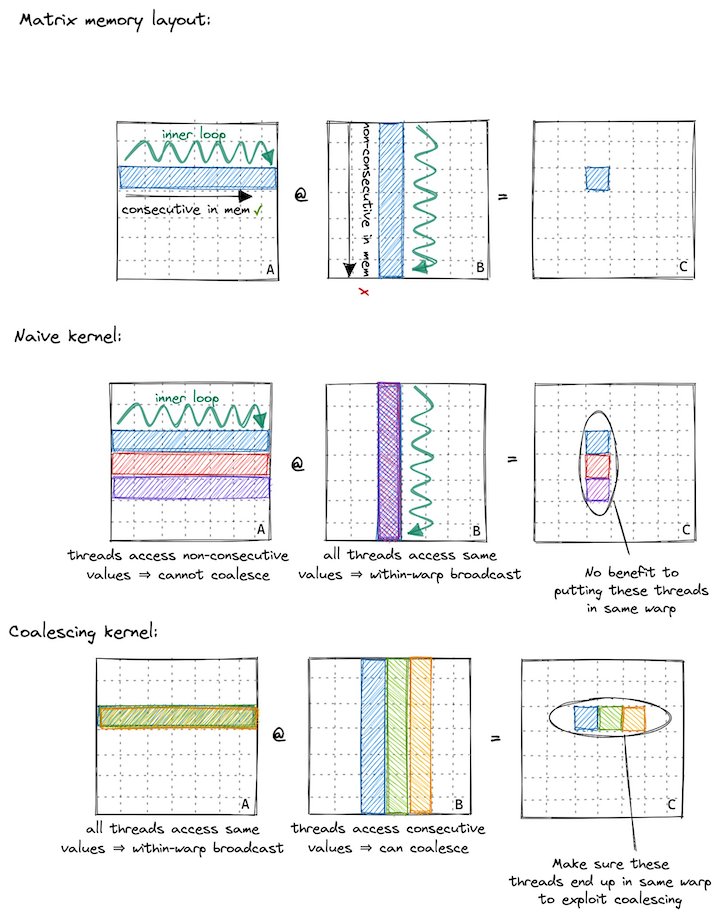

### **TODO 1:**

Implement global memory coalescing matmul kernel using the template below.

In [10]:
cuda_source = """
#define BLOCK_SIZE 32

__global__ void matmul_kernel(const float* a, const float* b, float* c, int n) {
    int x = blockIdx.y * blockDim.y + threadIdx.y;
    int y = blockIdx.x * blockDim.x + threadIdx.x;

    float sum = 0;
    for (int k = 0; k < n; ++k) {
        sum += a[x * n + k] * b[k * n + y];
    }
    c[x * n + y] = sum;
}

torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b) {
    TORCH_CHECK(a.dim() == 2 && b.dim() == 2, "Inputs must be 2D tensors.");
    TORCH_CHECK(a.size(1) == b.size(0), "Inner dimensions must match.");
    TORCH_CHECK(a.size(0) == a.size(1) && b.size(0) == b.size(1), "Matrices must be square.");

    int n = a.size(0);
    torch::Tensor output = torch::zeros({n, n}, a.options().device(torch::kCUDA));

    dim3 gridDim(n/BLOCK_SIZE, n/BLOCK_SIZE);
    dim3 blockDim(BLOCK_SIZE, BLOCK_SIZE);

    matmul_kernel<<<gridDim, blockDim>>>(a.data_ptr<float>(), b.data_ptr<float>(), output.data_ptr<float>(), n);

    return output;
}
"""

cpp_source = "torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b);"

# Load the extension
my_kernel_lib_2 = load_inline(
    name="cpp_extension",
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions="my_cuda_matmul",
    extra_cuda_cflags=["-O2"],
)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [11]:
check_correctness(my_kernel_lib_2.my_cuda_matmul)
benchmark_matmul(my_kernel_lib_2.my_cuda_matmul)

Results match!
Benchmarking custom kernel...
My kernel TFLOPs per second: 0.59991, Average time: 0.22910 sec

Benchmarking PyTorch matmul...
PyTorch TFLOPs per second: 4.20143, Average time: 0.03271 sec


## Blocked (Tiled) Matrix Multiplication Using Shared Memory
Blocked matrix multiplication improves performance by leveraging on-chip **shared memory** to reduce redundant global memory accesses. Instead of each thread fetching individual elements from global memory, threads **within a block** collaboratively load small submatrices (tiles) into **fast shared memory**, perform local computations, and accumulate results before writing to global memory.


1. Partitioning the Matrices:
   - The input matrices are divided into tiles of size `blockDim.x × blockDim.y`.
   - Each block computes a submatrix of the output.

2. Loading Tiles into Shared Memory:
   - Threads in each block cooperatively load a tile from matrix A and a tile from matrix B into shared memory.
   - This minimizes repeated memory accesses by ensuring each element is loaded only once per tile.

3. Computing Partial Sums:
   - Each thread computes a partial dot product for its assigned output element by iterating over shared memory tiles.  
   - Synchronization (`__syncthreads()`) ensures that all threads have finished loading a tile before computation begins.  
   - Another synchronization (`__syncthreads()`) ensures all threads have completed their computation before loading the next tile.

4. Accumulating Results and Storing in Global Memory:
   - Threads iterate over all necessary tiles, accumulating partial sums.
   - After all tiles are processed, the final result is written to global memory.

### **TODO 2:**

Implement blocked matrix multiplication using **shared memory**.
- Block dimension: 32 × 32
- Grid dimension: 128 × 128

In [ ]:
cuda_source = """
#define BLOCK_SIZE 32

__global__ void matmul_kernel(const float* a, const float* b, float* c, int n) {

}

torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b) {
    TORCH_CHECK(a.dim() == 2 && b.dim() == 2, "Inputs must be 2D tensors.");
    TORCH_CHECK(a.size(1) == b.size(0), "Inner dimensions must match.");
    TORCH_CHECK(a.size(0) == a.size(1) && b.size(0) == b.size(1), "Matrices must be square.");

    int n = a.size(0);
    torch::Tensor output = torch::zeros({n, n}, a.options().device(torch::kCUDA));

    dim3 gridDim(n / BLOCK_SIZE, n / BLOCK_SIZE);
    dim3 blockDim(BLOCK_SIZE, BLOCK_SIZE);

    matmul_kernel<<<gridDim, blockDim>>>(a.data_ptr<float>(), b.data_ptr<float>(), output.data_ptr<float>(), n);

    return output;
}
"""

cpp_source = "torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b);"

# Load the extension
my_kernel_lib_3 = load_inline(
    name="cpp_extension",
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions="my_cuda_matmul",
    extra_cuda_cflags=["-O2"],
)

In [ ]:
check_correctness(my_kernel_lib_3.my_cuda_matmul)
benchmark_matmul(my_kernel_lib_3.my_cuda_matmul)

## cuBLAS
[BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) defines a standardized set of routines for performing common operations on scalars (level 1), vectors (level 2), and matrices (level 3). It does not prescribe a specific implementation but serves as an interface for optimized linear algebra computations. Various libraries provide BLAS implementations across different programming languages and hardware platforms. For CUDA-based computations, cuBLAS offers a high-performance implementation of BLAS functions optimized for NVIDIA GPUs.

To use cuBLAS, include the header `cublas_v2.h` and link the library with `-lcublas`. We must create a handle before using cuBLAS functions:

```cpp
cublasHandle_t handle;
stat = cublasCreate(&handle);
if (stat != CUBLAS_STATUS_SUCCESS) {
    printf ("CUBLAS initialization failed\n");
    return EXIT_FAILURE;
}

// use cuBLAS functions
cublasSgemm(handle,transpA,transpB,m,n,k,&alpha,&A,lda,&B,ldb,&beta,&C,ldc);

cublasDestroy(handle);
```
### Code Explanation

The function `cublasSgemm()` is a core operation in cuBLAS. The **S**  in `Sgemm` denotes single precision, while **gemm**  stands for general matrix-matrix multiplication. A full list of available cuBLAS functions and their description can be found in the [official documentation](https://docs.nvidia.com/cuda/cublas/index.html#cublas-level-3-function-reference).

This function performs the matrix-matrix multiplication:

$
 C = \alpha \cdot \text{op}(A) \cdot \text{op}(B) + \beta \cdot C
$

where $\alpha$ and $\beta$ are scalars, and $A$, $B$, and $C$ are matrices stored in **column-major** format with dimensions $\text{op}(A) : m \times k$, $\text{op}(B) : k \times n$, and $C : m \times n$, respectively.

Also, for matrix $A$:
$
 \text{op}(A) =
\begin{cases}
A  & \text{if } \text{transa} == {CUBLAS\_OP\_N} \\
A^T  & \text{if } \text{transa} == {CUBLAS\_OP\_T} \\
A^H  & \text{if } \text{transa} == {CUBLAS\_OP\_C} \\
\end{cases}
$

and $\text{op}(B)$ is defined similarly for matrix $B$.


- $\text{lda}, \text{ldb}, \text{ldc}$ - number of rows of $A, B, C$.

- $m$ - number of rows of matrix $\text{op}(A)$ and $C$.

- $n$ - number of columns of matrix $\text{op}(B)$ and $C$.

- $k$ - number of columns of $\text{op}(C)$ and rows of $\text{op}(B)$.

### **TODO 3:**
Implement FP32 matrix multiplication using the `cublasSgemm()` function that takes **row-major format** input and returns **row-major format** output.

Note that the cuBLAS library uses **column-major storage** , whereas PyTorch Tessors use **row-major storage**. Directly following the `cublasSgemm` input definition to compute $A \cdot B$ can lead to an incorrect interpretation of matrix dimensions and produce unintended results. To solve this, we can convert a matrix from row-major to column-major storage (or vice versa) through transposition. Can you come up with a solution without tranposing any input or output matrix?

**Hint:** $B^T \cdot A^T = (A \cdot B)^T$

In [ ]:
cuda_source = """
#include <ATen/cuda/CUDAContext.h>
#include <cublas_v2.h>

torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b) {
    TORCH_CHECK(a.dim() == 2 && b.dim() == 2, "Inputs must be 2D tensors.");
    TORCH_CHECK(a.size(1) == b.size(0), "Inner dimensions must match.");
    TORCH_CHECK(a.size(0) == a.size(1) && b.size(0) == b.size(1), "Matrices must be square.");

    int n = a.size(0);
    torch::Tensor output = torch::zeros({n, n}, a.options().device(torch::kCUDA));

    // Create cuBLAS handle
    cublasHandle_t handle;
    cublasCreate(&handle);

    // Get current CUDA stream
    cudaStream_t stream = at::cuda::getCurrentCUDAStream(a.device().index());
    cublasSetStream(handle, stream);

    // Your code starts here

    // Destroy the cuBLAS handle
    cublasDestroy(handle);

    return output;
}
"""

cpp_source = "torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b);"

# Load the extension
my_kernel_lib_4 = load_inline(
    name="cpp_extension",
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions="my_cuda_matmul",
    extra_cuda_cflags=["-O2", "-lcublas"],
)

In [ ]:
check_correctness(my_kernel_lib_4.my_cuda_matmul)
benchmark_matmul(my_kernel_lib_4.my_cuda_matmul)

## Tensor Core Usage in CUDA

Tensor Cores are specialized hardware units in NVIDIA GPUs designed to accelerate matrix-matrix multiplications. The following CUDA kernel demonstrates how to use **Warp Matrix Multiply-Accumulate (WMMA)** APIs to perform **16x16** matrix multiplication using Tensor Cores.

```cpp
#include <mma.h>
using namespace nvcuda;
       
__global__ void wmma_ker(half *a, half *b, float *c) {
   // Declare the fragments
   wmma::fragment<wmma::matrix_a, 16, 16, 16, half, wmma::row_major> a_frag;
   wmma::fragment<wmma::matrix_b, 16, 16, 16, half, wmma::row_major> b_frag;
   wmma::fragment<wmma::accumulator, 16, 16, 16, float> c_frag;

   // Initialize the output to zero
   wmma::fill_fragment(c_frag, 0.0f);

   // Load the inputs
   wmma::load_matrix_sync(a_frag, a, 16);
   wmma::load_matrix_sync(b_frag, b, 16);

   // Perform the matrix multiplication
   wmma::mma_sync(c_frag, a_frag, b_frag, c_frag);

   // Store the output
   wmma::store_matrix_sync(c, c_frag, 16, wmma::mem_row_major);
}
```

#### Code Explanation
Unlike traditional CUDA matrix multiplication, where each thread computes a single element of C, Tensor Cores process an entire 16×16 matrix tile using just **32 threads (one warp)**.

1. **Using WMMA Fragments**
    - The kernel declares three WMMA fragments, which serve as containers for matrix tiles:
        - `a_frag` holds a 16×16 tile from matrix A (half precision, row-major).
        - `b_frag` holds a 16×16 tile from matrix B (half precision, row-major).
        - `c_frag` holds the 16×16 output tile (**float** precision), as the accumulation results in Tensor Cores are in FP32.

2. **Initializing the Output**
    - The `c_frag` accumulator is initialized to zero using `wmma::fill_fragment()`.

3. **Loading Matrices into Fragments**
    - `wmma::load_matrix_sync()` loads 16×16 tiles from global memory into Tensor Core registers.

4. **Performing Matrix Multiplication Using Tensor Cores**
    - `wmma::mma_sync(c_frag, a_frag, b_frag, c_frag)` performs matrix multiplication using Tensor Cores.

5. **Storing the Output**
    - `wmma::store_matrix_sync()` writes the computed 16×16 tile from the accumulator back to global memory in row-major order.


### **TODO 4:**

Implement tensor core enabled matrix multiplication using **global memory**.
- Block dimension: 32 × 1 (one warp per block)
- Grid dimension: 4096/16 × 4096/16 = 256 x 256

Each thread block is responsible for computing a 16×16 tile of matrix C. To achieve this, the computation follows a tiled matrix multiplication approach as the previous section, where each tile is loaded from global memory in 16×16 blocks, processed using Tensor Cores, and accumulated in FP32 precision before being stored back in global memory.

In [ ]:
cuda_source = """
#include <cuda_fp16.h>
#include <mma.h>

using namespace nvcuda;

#define WMMA_M 16
#define WMMA_N 16
#define WMMA_K 16

__global__ void wmma_matmul_kernel(half* a, half* b, float* c, int n) {

}

torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b) {
    TORCH_CHECK(a.dim() == 2 && b.dim() == 2, "Inputs must be 2D tensors.");
    TORCH_CHECK(a.size(1) == b.size(0), "Inner dimensions must match.");
    TORCH_CHECK(a.size(0) == a.size(1) && b.size(0) == b.size(1), "Matrices must be square.");

    int n = a.size(0);
    // Create an output tensor with fp32 type on CUDA.
    torch::Tensor output_fp32 = torch::zeros({n, n}, a.options().dtype(torch::kFloat).device(torch::kCUDA));

    // For 4096x4096 matrices, grid dimensions become 4096/16 = 256 in each dimension.
    dim3 gridDim(n / WMMA_M, n / WMMA_N);
    // Launch with 32 threads (one warp) per block.
    dim3 blockDim(32, 1, 1);

    // Launch the WMMA kernel.
    wmma_matmul_kernel<<<gridDim, blockDim>>>(
        reinterpret_cast<half*>(a.data_ptr<at::Half>()),
        reinterpret_cast<half*>(b.data_ptr<at::Half>()),
        output_fp32.data_ptr<float>(),
        n
    );

    // Convert the output tensor to fp16.
    torch::Tensor output = output_fp32.to(torch::kHalf);
    return output;
}
"""

cpp_source = "torch::Tensor my_cuda_matmul(torch::Tensor a, torch::Tensor b);"

# Load the extension
my_kernel_lib_5 = load_inline(
    name="cpp_extension",
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions="my_cuda_matmul",
    extra_cuda_cflags=["-O2"],
)

Note that the input data type is changed to half precision since Tensor Cores only support half precision computation. PyTorch's default kernel also leverages Tensor Cores, which contributes to its improved performance.

In [ ]:
check_correctness(my_kernel_lib_5.my_cuda_matmul, dtype=torch.float16)
benchmark_matmul(my_kernel_lib_5.my_cuda_matmul, dtype=torch.float16)